In [ ]:
!unzip /content/drive/MyDrive/datasets/glove.zip -d /content/

In [26]:
!apt install libomp-dev
!pip install faiss
!pip install faiss-gpu
import faiss  

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 1s (216 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Selecting previously unselected package libomp-dev.
Preparing to unpack .../libomp-dev_5.0.1-1_amd64.deb ...
Unpacking libomp-dev (5.0.1-

In [ ]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

In [1]:
!pip install --upgrade xgboost
from xgboost import XGBClassifier

     |████████████████████████████████| 166.7MB 67kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [4]:
import pandas as pd
import numpy as np
import re
import sys
import json
import csv
import gc
from collections import Counter
import glob
import os.path
import time
import nltk
from random import *
import ast
import os
import joblib
import matplotlib.pyplot as plt
import math
from google.colab import drive
import requests_oauthlib
from scipy.spatial import distance
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)  # or 199

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


In [6]:
# Load word frequency dataset and create a 'rel_freq' variable indicating 'politicalness' of a word.
df = pd.read_csv("/content/drive/MyDrive/datasets/reddit/extracted_keywords_freq.csv")
df["rel_freq"] = (df["pol_freq"]*df["total_freq"].sum())/(df["total_freq"]*df["pol_freq"].sum())-1

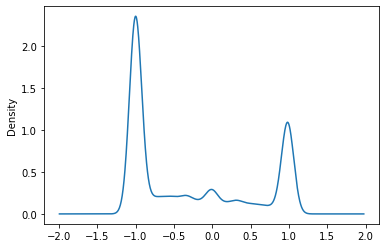

In [7]:
df["rel_freq"].plot.kde()

In [8]:
df.head(n=50)

,word,non_pol_freq,pol_freq,total_freq,rel_freq
0,people,47177.0,72710.0,119887.0,0.203846
1,like,61796.0,49373.0,111169.0,-0.118434
2,trump,976.0,47684.0,48660.0,0.945134
3,good,21394.0,14966.0,36360.0,-0.182984
4,edit,27668.0,5958.0,33626.0,-0.648298
5,likely,11868.0,17941.0,29809.0,0.194671
6,right,8847.0,20266.0,29113.0,0.381752
7,new,9841.0,13022.0,22863.0,0.130560
8,time,14329.0,7523.0,21852.0,-0.316641
9,things,13140.0,8173.0,21313.0,-0.238823


In [9]:
#word frequency dict
wfd = dict(zip(df.word, df.total_freq))

def get_most_common(x):  #get most frequent word from a phrase.
  if len(x)<2:
    return x
  word_freq = 0
  word_ret = ""
  for word in x.split():
    if (word in ["null","nan"]):
      continue
    elif (wfd[word]>word_freq):
      word_ret = word
      word_freq = wfd[word]
  return word_ret

def split_words(lst):
  ret_list = []
  for i in lst:
    ret_list.append(get_most_common(i))
  return ret_list

In [10]:
# Test and train dataset. Contains keywords extracted from paragraph using textrank.
df_main = pd.read_csv("/content/drive/MyDrive/datasets/reddit/train_dataset.csv")
df_main["keywords"] = df_main["keywords"].apply(ast.literal_eval)
df_main["text_rank_scores"] = df_main["text_rank_scores"].apply(ast.literal_eval)
df_main["keywords"] = df_main["keywords"].apply(split_words) #Resolve compound words.
df_main = df_main.sample(frac=1).reset_index(drop=True) #Shuffle

In [12]:
#test train splits for both categories
split_pos = 0.2
split_neg = 0.2

#removing some subreddits that are hard to classify. 
df_main = df_main[~df_main["subreddit"].isin(("badeconomics","askeconomics", "economics","politicalcompassMemes"))]

df_pos = df_main[df_main["label"]==1]
df_neg = df_main[df_main["label"]==0]

df_pos_train,df_pos_test = train_test_split(df_pos, test_size=split_pos)
df_neg_train,df_neg_test = train_test_split(df_neg, test_size=split_neg)

df_train = pd.concat([df_pos_train, df_neg_train], ignore_index=True)
df_test = pd.concat([df_pos_test, df_neg_test], ignore_index=True)

In [13]:
len_pos = len(df_pos_train)
len_neg = len(df_neg_train)
len_tot = len_pos+len_neg
print(f"pos: {len_pos/len_tot}, neg: {len_neg/len_tot}")

pos: 0.527515998345946, neg: 0.472484001654054


In [14]:
len_pos = len(df_pos_test)
len_neg = len(df_neg_test)
len_tot = len_pos+len_neg
print(f"pos: {len_pos/len_tot}, neg: {len_neg/len_tot}")

pos: 0.5275114221271181, neg: 0.47248857787288184


In [15]:
rel_freq_dict = dict(zip(df["word"], df["rel_freq"]))

def get_rel_freq(x,text_rank_scores):
  try:
    ret = [rel_freq_dict[x]]
  except:
    ret = [0.0] # not found
  return ret

def get_x(xs,text_rank_scores):
  ret_val = []
  
  for i in range(len(xs)):
    ret_val.extend(get_rel_freq(xs[i],text_rank_scores[i]))

  ret_val = np.sort(np.array(ret_val))[::-1]
  ret_val = np.pad(ret_val, (0, max(0,10-len(ret_val))), 'constant') # Padding to 10 items
  return ret_val

In [16]:
x_train = np.stack(df_train.apply(lambda row: get_x(row["keywords"],row["text_rank_scores"]), axis=1))
y_train = np.array(df_train.label.astype(int))

x_test = np.stack(df_test.apply(lambda row: get_x(row["keywords"],row["text_rank_scores"]), axis=1))
y_test = np.array(df_test.label.astype(int))

In [17]:
def plot_cm(cf_matrix):
  group_names = ["True Neg","False Pos","False Neg","True Pos"]
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Logistic Regression

Prediction Accuracy on train: 0.9460639586833499
Prediction Accuracy on test: 0.9461106934243247


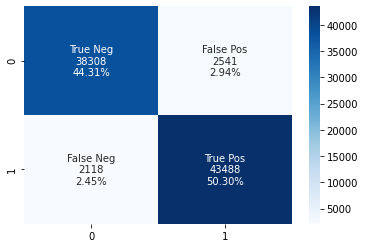

In [18]:
lr = LogisticRegression(random_state=0,max_iter=200)
lr.fit(x_train, y_train)

print(f"Prediction Accuracy on train: {lr.score(x_train, y_train)}")
print(f"Prediction Accuracy on test: {lr.score(x_test, y_test)}")
y_pred = lr.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_cm(cm)

In [ ]:
joblib.dump(lr, "lr_train_50_pos.sav")

['lr_train_20_pos.sav']

In [ ]:
print(lr.coef_, lr.intercept_)

[[3.93046247 1.81532622 0.99551    0.67375188 0.70904757 0.38134367
  0.8121919  0.74829088 0.83665252 3.05491921]] [-0.98434933]


In [22]:
## False Negatives
wrong = df_test[(y_pred==0) & (y_test == 1)].keywords
for i in wrong.sample(n=5):
  print(dict(zip(i, get_x(i,[i for i in range(10)]))))

{'market': 0.46212626953698743, 'tooth': 0.31692756124649946, 'comment': 0.2636887887071384, 'returns': -0.26388700012619437, 'money': -0.28760217054493953, 'mouth': -0.35902747375853283, 'teeth': -0.38229549521149897, 'nah': -0.6248686136743486, 'holy': -0.8082721475758661, 'place': -0.8549680428654116}
{'children': 0.7850244406817373, 'eye': 0.25713321275745815, 'good': 0.03400378533055126, 'sexual': 0.027332370708451403, 'personally': -0.06404706400877369, 'color': -0.15771024508648157, 'advertiser': -0.18298351302205484, 'james': -0.19506388321597545, 'makes': -0.5492826708515008, 'cbs': -0.7541773601575601}
{'feeling': 0.307560447052708, 'like': 0.2038461994640759, 'lets': 0.18811226771776446, 'extra': 0.14165284898339947, 'aren': 0.10482908966271154, 'things': -0.11843412263063702, 'starting': -0.23882263003306314, 'country': -0.46582155923019153, 'people': -0.5158665419419288, 'tough': -0.77760727995983}
{'memes': 0.2876589421933289, 'syntax': 0.07420670811473218, 'like': 0.0356

In [23]:
## False Positives
wrong = df_test[(y_pred==1) & (y_test == 0)].keywords
for i in wrong.sample(n=5):
  print(dict(zip(i, get_x(i,[i for i in range(10)]))))

{'votes': 0.9590726338178561, 'like': 0.9231914950601907, 'state': 0.9038829711074381, 'people': 0.7532656462166112, 'car': 0.5793275373085689, 'electoral': 0.2038461994640759, 'presidential': 0.07939712250650621, 'city': -0.11843412263063702, 'friends': -0.5929447971479421, 'institution': -0.8230820943392727}
{'ruth': 0.8885523200362422, 'today': 0.45053832241245173, 'great': 0.29802680045315033, 'free': 0.24629481700239197, 'fooking': 0.16100683998454435, 'office': 0.08908606228638671, 'cashmere': -0.07841738162517164, 'presidents': -0.30821642904018975, 'salary': -0.7164361174231297, 'mob': -1.0}
{'james': 0.8476347200126897, 'officer': 0.6057878956531102, 'ted': 0.37574201497735693, 'christmas': 0.21544485141690606, 'propaganda': 0.11638712126839068, 'white': -0.017451146871144463, 'literally': -0.11843412263063702, 'like': -0.19506388321597545, 'escobar': -0.5618746824912373, 'reads': -1.0}
{'state': 0.7532656462166112, 'construction': 0.6622410417312856, 'truck': 0.49498778702706

KNN

In [24]:
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [27]:
fknn = FaissKNeighbors(k=5)
fknn.fit(x_train,y_train)

0.9429529813197617


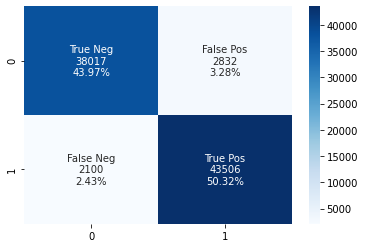

In [28]:
y_pred = fknn.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.accuracy_score(y_test,y_pred))
plot_cm(cm)

XGBoost

In [29]:
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(x_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_pred = xgb.predict(x_test)
prediction_end = time.perf_counter()
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print(f"XGBoost's prediction accuracy is: {acc_xgb}")
print(f"Time consumed for training: {xgb_train_time}")
print(f"Time consumed for prediction: {xgb_prediction_time}")

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:32:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost's prediction accuracy is: 95.06679775605807
Time consumed for training: 28.096654265000097
Time consumed for prediction: 0.16308285900004194


In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.accuracy_score(y_test,y_pred))
plot_cm(cm)

Random Forest

In [31]:
clf=RandomForestClassifier(n_estimators=50,max_depth=40)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9493840726389451


In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.accuracy_score(y_test,y_pred))
plot_cm(cm)

Simple Neural Network

In [ ]:
model = Sequential()
model.add(Dense(30))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=3,batch_size=10, verbose=1)
_, accuracy = model.evaluate(x_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Using Embeddings

In [ ]:
embeddings= {}
with open("/content/glove/glove.840B.300d.txt", 'r') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings[word]=vector

In [ ]:
def get_embedding(x):
  try:
    return embeddings[x]
  except:
    return np.zeros(shape=(300))

In [ ]:
word_to_ind = {}
ind_to_word = {}
embeddings_ds = []

for ind,word in enumerate(list(df["word"])):
  word_to_ind[word]=ind
  ind_to_word[ind]=word
  embeddings_ds.append(get_embedding(word))
embeddings_ds = np.array(embeddings_ds,dtype="float32")

In [ ]:
embeddings_ds[:10]

In [ ]:
index = faiss.IndexFlatL2(300)  
index.add(embeddings_ds)
print(index.ntotal)

In [ ]:
get_nearest(x):
  D, I = index.search(np.array([get_embedding(x), 1) # sanity check
  return ind_to_word[I[0][0]]